# Ir Além 2 — Classificação de ECG com MLP (Keras)

Neste notebook vamos:
- Baixar o dataset público do Kaggle (`heartbeat`)
- Pré-processar os sinais em imagens
- Treinar uma rede MLP (Perceptron Multicamadas) para classificar ECG em **normal vs. anormal**


In [1]:
!pip install -q tensorflow==2.16.1 pillow==10.3.0 scikit-learn==1.5.1 kaggle==1.6.14 numpy==1.26.4 --force-reinstall


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.16.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
jax 0.5.3 requires ml_dtypes>=0.4.0, but you have ml-dtypes 0.3.2 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.16.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tensorstore 0.1.76 requires ml_dtypes>=0

## 0) Baixar dataset do Kaggle

In [2]:
# Copiar seu kaggle.json (já deve estar em /content)
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixar dataset heartbeat
!kaggle datasets download -d shayanfazeli/heartbeat -p /content/

# Descompactar
!unzip -q /content/heartbeat.zip -d /content/

cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
heartbeat.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## 0.1) Converter CSVs em imagens para usar no MLP

In [3]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import resample

BASE_DIR = "/content/"
OUT_DIR = "/content/ecg"

os.makedirs(os.path.join(OUT_DIR, "normal"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "abnormal"), exist_ok=True)

# Arquivos do Kaggle (dataset heartbeat)
normal_csv = os.path.join(BASE_DIR, "ptbdb_normal.csv") # Corrected path
abnormal_csv = os.path.join(BASE_DIR, "ptbdb_abnormal.csv") # Corrected path

# Carregar os CSVs
df_normal = pd.read_csv(normal_csv, header=None)
df_abnormal = pd.read_csv(abnormal_csv, header=None)

print("Antes do balanceamento -> Normal:", df_normal.shape, "Anormal:", df_abnormal.shape)

# Balancear dataset (undersampling da classe maior (anormal) para igualar à menor (normal))
df_abnormal_bal = resample(df_abnormal,
                         replace=False,
                         n_samples=len(df_normal),
                         random_state=42)

print("Após balanceamento -> Normal:", df_normal.shape, "Anormal:", df_abnormal_bal.shape)


# Combine the balanced dataframes
df_balanced = pd.concat([df_normal, df_abnormal_bal])


# Função para converter sinais em imagens
def save_signals_as_images(df, out_dir, label):
    for i, row in df.iterrows():
        signal = row.values[:-1]  # últimos valores = rótulo
        img = np.expand_dims(signal, axis=0)  # linha única
        img = np.tile(img, (128, 1))  # esticar para "imagem"
        im = Image.fromarray((img * 255).astype(np.uint8))
        im = im.resize((128,128))
        im.save(os.path.join(out_dir, f"{label}_{i}.png"))

# Salvar imagens normal e anormal do dataset balanceado
save_signals_as_images(df_normal, os.path.join(OUT_DIR,"normal"), "normal")
save_signals_as_images(df_abnormal_bal, os.path.join(OUT_DIR,"abnormal"), "abnormal")

Antes do balanceamento -> Normal: (4046, 188) Anormal: (10506, 188)
Após balanceamento -> Normal: (4046, 188) Anormal: (4046, 188)


## 1) Imports e configuração

In [ ]:
import os, glob, numpy as np, random
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_DIR = '/content/ecg'  # agora já temos pastas normal/ e abnormal/
NORMAL_DIR = os.path.join(DATA_DIR, 'normal')
ABN_DIR = os.path.join(DATA_DIR, 'abnormal')

IMG_SIZE = (128, 128)  # simples para MLP


## 2) Carregar imagens e rótulos

In [ ]:
from sklearn.model_selection import train_test_split

def load_images_from_folder(folder, label):
    X, y = [], []
    for fp in glob.glob(os.path.join(folder, '*')):
        try:
            img = Image.open(fp).convert('L').resize(IMG_SIZE)
            X.append(np.array(img) / 255.0)  # normaliza aqui (0-1)
            y.append(label)
        except Exception as e:
            print('Erro ao ler', fp, e)
    return X, y

# Carregar imagens normais e anormais
Xn, yn = load_images_from_folder(NORMAL_DIR, 0)
Xa, ya = load_images_from_folder(ABN_DIR, 1)

# Concatenar
X = np.array(Xn + Xa)
y = np.array(yn + ya)

print('Total imagens:', len(X), ' - Normal:', len(Xn), ' - Anormal:', len(Xa))

# Separar em treino e teste diretamente nesta célula
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Split realizado -> Treino:", X_train.shape, "Teste:", X_test.shape)


Total imagens: 8092  - Normal: 4046  - Anormal: 4046
Split realizado -> Treino: (6069, 128, 128) Teste: (2023, 128, 128)


## 3) Preparar dados e criar MLP

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Normalização (já está em escala 0-1 porque as imagens foram salvas com intensidade 0-255)
X_train = X_train.reshape(-1, 128, 128, 1) / 255.0
X_test  = X_test.reshape(-1, 128, 128, 1) / 255.0

print("Novo shape -> Treino:", X_train.shape, "Teste:", X_test.shape)

# Criar o modelo MLP (versão 128x128)
model = Sequential([
    Flatten(input_shape=(128, 128, 1)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilar modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping -> para treino automaticamente se não melhorar
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,            # pode deixar 20, foi o que usamos antes
    batch_size=64,        # batch médio (nem muito pequeno, nem muito grande)
    callbacks=[early_stop],
    verbose=1
)


Novo shape -> Treino: (6069, 128, 128, 1) Teste: (2023, 128, 128, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.7184 - loss: 0.5700 - val_accuracy: 0.7202 - val_loss: 0.5462
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7820 - loss: 0.4784 - val_accuracy: 0.7672 - val_loss: 0.4781
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8013 - loss: 0.4478 - val_accuracy: 0.7850 - val_loss: 0.4478
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8122 - loss: 0.4250 - val_accuracy: 0.7954 - val_loss: 0.4334
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8258 - loss: 0.4012 - val_accuracy: 0.7983 - val_loss: 0.4217
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8369 - loss: 0.3845 - val_accuracy: 0.8003 - val_loss: 0.4103
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8453 - loss: 0.3636 - val_accuracy: 0.7983 - val_loss: 0.4098
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8527 - loss: 0.3468 - val_accuracy: 0.8067 - 

## 4) Treinar

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=12, batch_size=32, verbose=1)

Epoch 1/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9038 - loss: 0.2469 - val_accuracy: 0.9168 - val_loss: 0.2392
Epoch 2/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9001 - loss: 0.2505 - val_accuracy: 0.9061 - val_loss: 0.2454
Epoch 3/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9040 - loss: 0.2400 - val_accuracy: 0.9185 - val_loss: 0.2310
Epoch 4/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9102 - loss: 0.2269 - val_accuracy: 0.9259 - val_loss: 0.2363
Epoch 5/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9162 - loss: 0.2152 - val_accuracy: 0.9275 - val_loss: 0.2361
Epoch 6/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9193 - loss: 0.2159 - val_accuracy: 0.9292 - val_loss: 0.2294
Epoch 7/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9226 - loss: 0.2064 - val_accuracy: 0.9308 - val_loss: 0.2226
Epoch 8/12
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9244 - loss: 0.2023 - val_a

## 5) Avaliar

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

      normal       0.88      0.95      0.92      1012
     anormal       0.95      0.87      0.91      1011

    accuracy                           0.91      2023
   macro avg       0.92      0.91      0.91      2023
weighted avg       0.92      0.91      0.91      2023



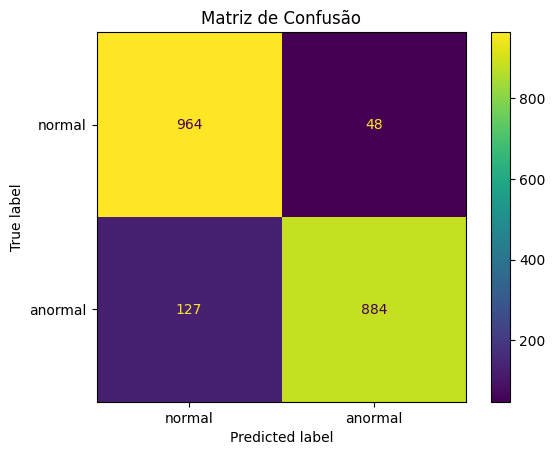

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Previsões
pred = (model.predict(X_test) > 0.5).astype('int32').ravel()

# Relatório de classificação forçando as 2 classes
print(classification_report(
    y_test,
    pred,
    labels=[0,1],
    target_names=['normal','anormal']
))

# Matriz de confusão forçando as 2 classes
cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['normal','anormal'])
disp.plot()
plt.title('Matriz de Confusão')
plt.show()
